In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!git clone https://github.com/amcs1729/Predicting-cloud-CPU-usage-on-Azure-data.git

fatal: destination path 'Predicting-cloud-CPU-usage-on-Azure-data' already exists and is not an empty directory.


In [ ]:
import numpy as np
%matplotlib inline 
import pandas as pd
import tensorflow as tf
from IPython.display import display, Image
import cv2
from PIL import Image
from tqdm import tqdm
from keras.applications.vgg19 import VGG19
from keras.utils.vis_utils import plot_model
import gc
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error

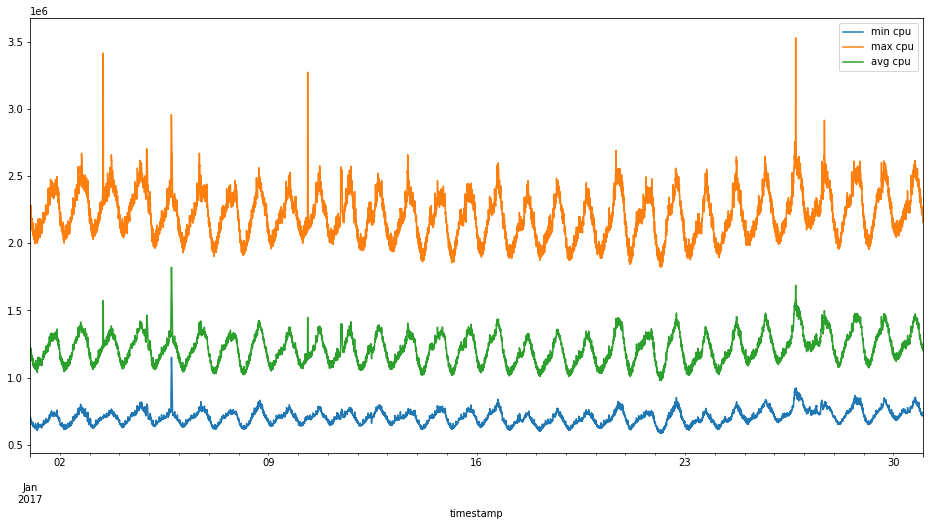

In [ ]:
df = pd.read_csv('/content/Predicting-cloud-CPU-usage-on-Azure-data/azure.csv')
df['timestamp'] =  pd.to_datetime(df['timestamp'])
df = df.set_index('timestamp')
df.head()
df.plot(figsize=(16, 8))
plt.show()

In [ ]:
TRAIN_LENGTH = round(len(df)*0.8)
TEST_LENGTH = len(df) - TRAIN_LENGTH
train = df.iloc[0:TRAIN_LENGTH]
test = df[TRAIN_LENGTH : ]

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = pd.DataFrame(scaler.fit_transform(train), columns=df.columns)
test_scaled = pd.DataFrame(scaler.transform(test), columns=df.columns)

In [ ]:
def train_generator(dataset, n_lags=1):
    dataX, dataY = [], []
    for i in range(len(dataset)- n_lags -1):
        a = dataset.iloc[i:(i+n_lags)].to_numpy()
        dataX.append(a)
        dataY.append(dataset.iloc[i + n_lags].to_numpy())
    return (np.array(dataX), np.array(dataY))

In [ ]:
TIME_STEPS = 500
X_train, y_train = train_generator(train_scaled, n_lags = TIME_STEPS)
X_test_scaled, y_test_scaled = train_generator(test_scaled, n_lags = TIME_STEPS)
X_test, y_test = train_generator(test, n_lags = TIME_STEPS)

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.GRU(512,input_shape=(X_train.shape[1], X_train.shape[2]),return_sequences=True))
model.add(tf.keras.layers.GRU(512,return_sequences=False))
model.add(tf.keras.layers.Dense(3))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 500, 512)          794112    
_________________________________________________________________
gru_3 (GRU)                  (None, 512)               1575936   
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1539      
Total params: 2,371,587
Trainable params: 2,371,587
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='mean_absolute_error', optimizer= tf.keras.optimizers.Adam())

In [ ]:
es = tf.keras.callbacks.EarlyStopping( monitor='val_loss', patience=8, verbose=1, restore_best_weights=True)
lr_red = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, verbose=1, min_lr=0.0000001,)

In [ ]:
callbacks = [es , lr_red]
history = model.fit(X_train, y_train, 
                    epochs=200, 
                    validation_split=0.25,
                    batch_size=512,
                    verbose=1, 
                    shuffle=False, 
                    callbacks = callbacks)


Epoch 1/200
10/10 [==============================] - 541s 54s/step - loss: 0.0777 - val_loss: 0.0321
Epoch 2/200
10/10 [==============================] - 521s 52s/step - loss: 0.0373 - val_loss: 0.0296
Epoch 3/200
10/10 [==============================] - 534s 54s/step - loss: 0.0263 - val_loss: 0.0256
Epoch 4/200
10/10 [==============================] - 517s 52s/step - loss: 0.0235 - val_loss: 0.0196
Epoch 5/200
10/10 [==============================] - 525s 52s/step - loss: 0.0206 - val_loss: 0.0194
Epoch 6/200
10/10 [==============================] - 528s 53s/step - loss: 0.0195 - val_loss: 0.0175
Epoch 7/200
10/10 [==============================] - 531s 53s/step - loss: 0.0200 - val_loss: 0.0191
Epoch 8/200
10/10 [==============================] - 532s 53s/step - loss: 0.0206 - val_loss: 0.0218
Epoch 9/200
10/10 [==============================] - 541s 54s/step - loss: 0.0206 - val_loss: 0.0206
Epoch 10/200
10/10 [==============================] - 556s 56s/step - loss: 0.0194 - val_lo

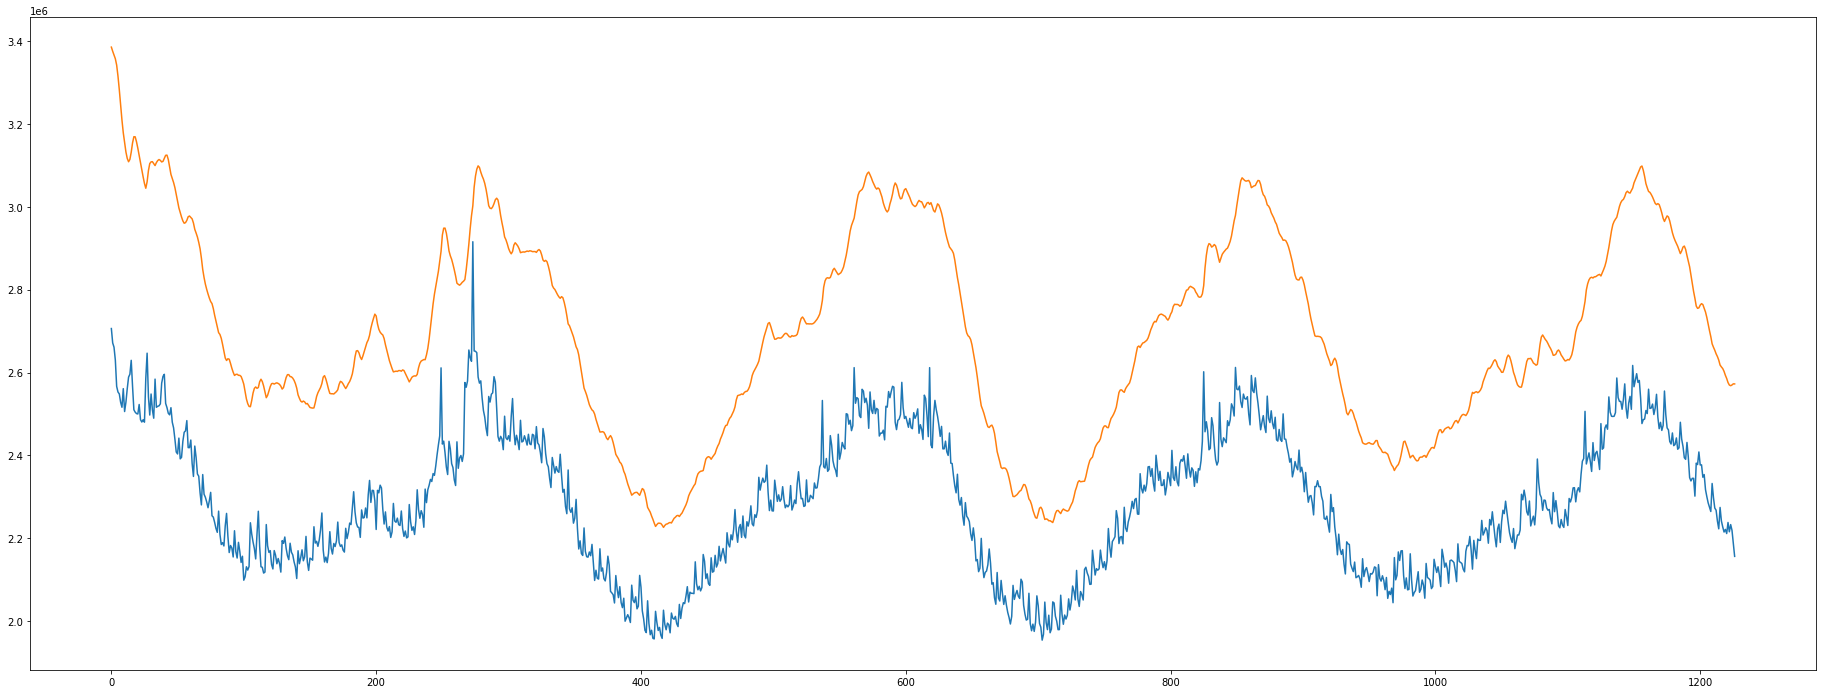

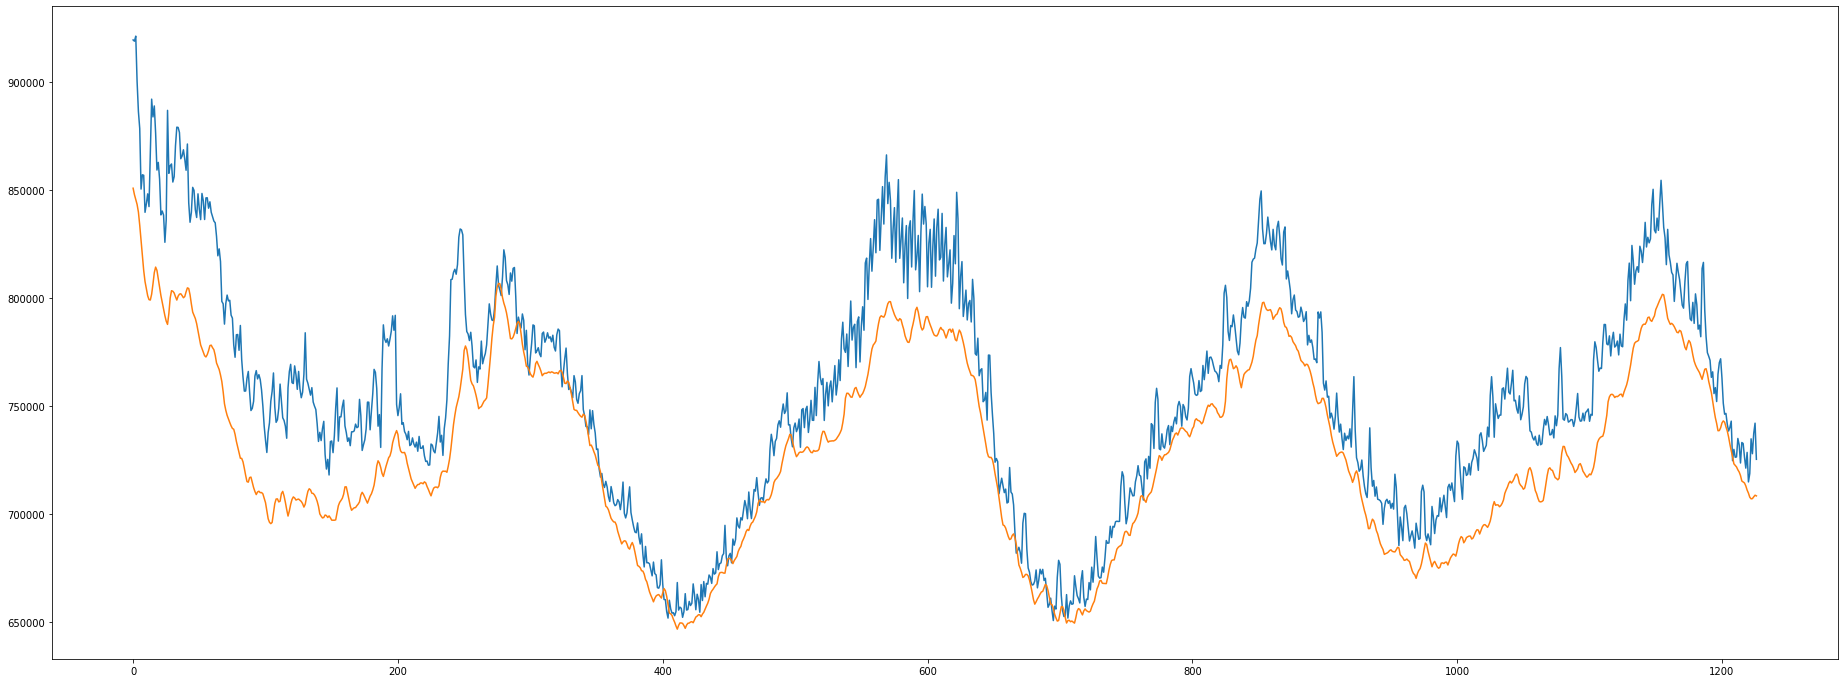

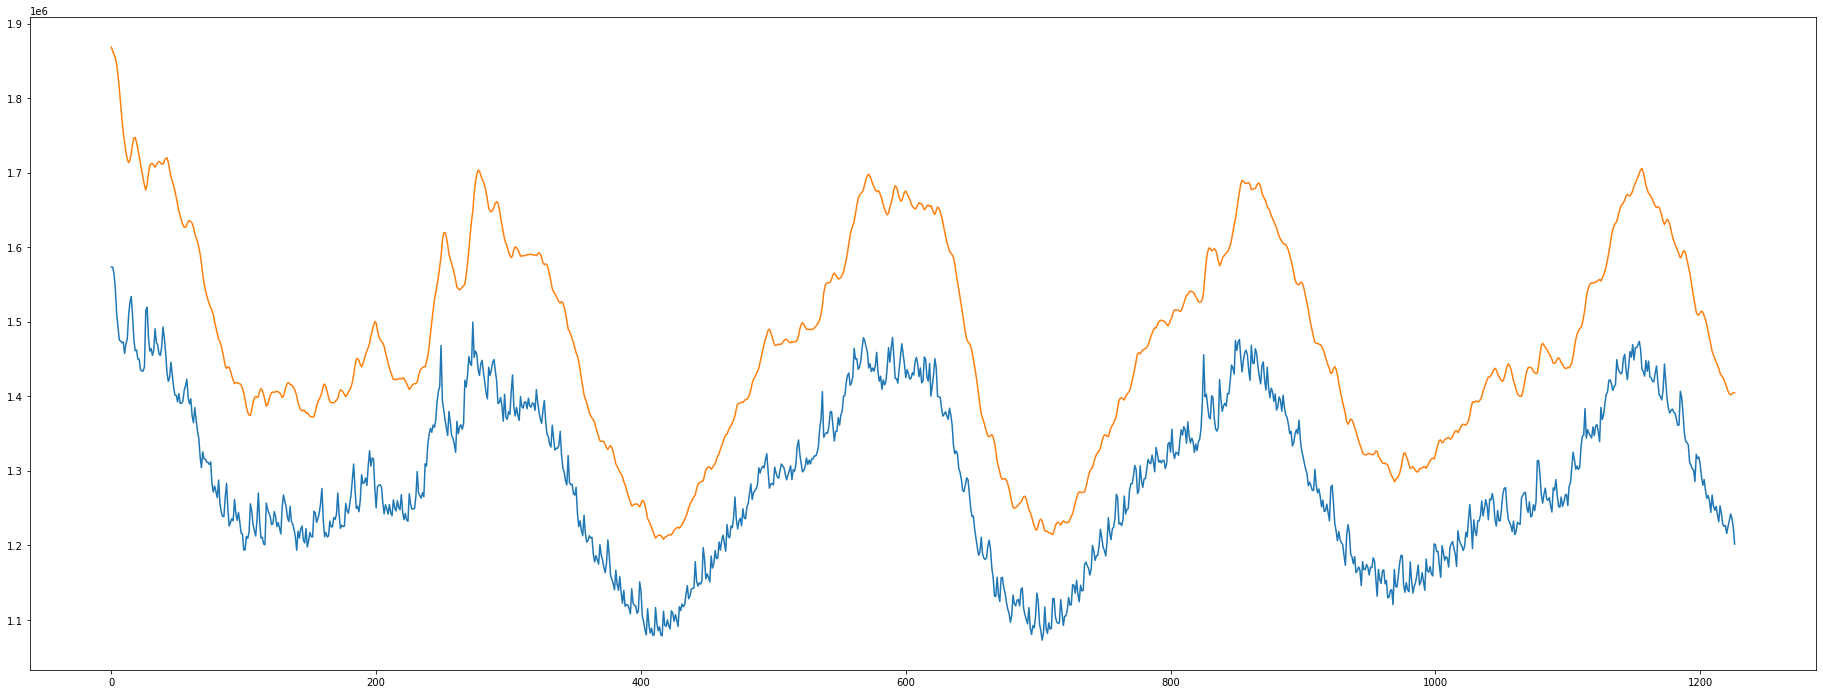

In [ ]:
preds = model.predict(X_test_scaled)
preds = scaler.inverse_transform(preds)
plt.rcParams["figure.figsize"] = (32,12)
TestY= pd.DataFrame(y_test,columns=['min_cpu','max_cpu','avg_cpu'])
PredY=pd.DataFrame(preds,columns=['min_cpu','max_cpu','avg_cpu'])


plot_max = plt.figure(1)
plt.plot(TestY['max_cpu'])
plt.plot(PredY['max_cpu'])
plt.show()

plot_min = plt.figure(2)
plt.plot(TestY['min_cpu'])
plt.plot(PredY['min_cpu'])
plt.show()

plot_avg = plt.figure(3)
plt.plot(TestY['avg_cpu'])
plt.plot(PredY['avg_cpu'])
plt.show()


In [ ]:
testScore_1 = math.sqrt(mean_squared_error(y_test[:], preds[:]))
print('Test Score: %.2f RMSE' % (testScore_1))

testScore_2 = math.sqrt(mean_absolute_error(y_test[:], preds[:]))
print('Test Score: %f MAE' % (testScore_2))

testScore_3 = np.mean(np.abs(preds - y_test)/np.abs(y_test)*100)
print('Test Score: %f MAPE' % (testScore_3))

Test Score: 264137.44 RMSE
Test Score: 452.470527 MAE
Test Score: 11.703875 MAPE
